# README

In [1]:
README = '''
Julian Smoller ~ 4/7/2017

# Intro:
The purpose of this notebook is to create some 
interesting functions to manipulate the colors
in an image: specifically, to pixelate an image.
'''
print(README)

%run commons.py
%matplotlib inline


Julian Smoller ~ 4/7/2017

# Intro:
The purpose of this notebook is to create some 
interesting functions to manipulate the colors
in an image: specifically, to pixelate an image.



# Load + show image

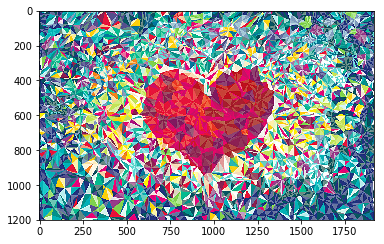

In [3]:
path_in = 'data/input/heart_prism.jpg'
im = Image.open(path_in)
show(im)

# Parse colors: mean and mode

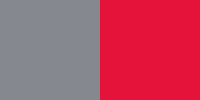

In [4]:
def get_mean_color(im):
    '''Calculate the mean pixel color in an image'''
    data = list(im.getdata())
    df = pd.DataFrame(data)
    mean_color = tuple([int(df[c].mean()) for c in df.columns])
    return mean_color

def get_mode_color(im):
    '''Calculate the mode pixel color in an image'''
    data = list(im.getdata())
    data = pd.Series(data)
    mode_colors = data.mode()
    if len(mode_colors)==1: 
        mode_color = mode_colors[0]
    elif len(mode_colors)>1: # several modes
        mode_color = mode_colors[0] # just pick first mode
    elif len(mode_colors)==0: # no modes <=> all unique colors
        mode_color = data[0] # just pick first pixel's color
    else:
        mode_color = (0,0,0) # set to white by default
    return mode_color

mean_color = get_mean_color(im)
mode_color = get_mode_color(im)
draw_colors([mean_color,mode_color])

# Dice image into boxes

In [7]:
def dice(im,w,h):
    '''Generate non-overlapping boxes of given size 
    based on dimensions of image; returns a list of tuples'''
    boxes = []
    for x in range(0,im.size[0],w):
        for y in range(0,im.size[1],h):
            boxes.append((x,y,x+w,y+h))
    return boxes

boxes = dice(im.crop((0,0,100,100)),53,53)
boxes

[(0, 0, 53, 53), (0, 53, 53, 106), (53, 0, 106, 53), (53, 53, 106, 106)]

# Pixelate

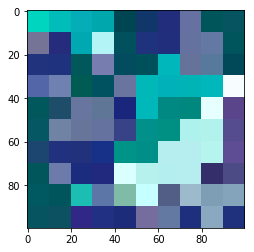

In [9]:
def pixelate(im,w=6,h=6,border=False):
    '''Recolor an image by taking the mode color within each block of given size;'''
    boxes = dice(im,w,h)
    for box in boxes:
        block = im.crop(box)
        color = get_mode_color(block)
        colored_block = set_color(block,color)
        if border:
            colored_block = add_border(colored_block)
        im.paste(colored_block,box)
    return im

im_small = im.crop((0,0,100,100))
im_pixelated = pixelate(im_small,w=10,h=10)
show(im_pixelated)

# Reduce to n colors

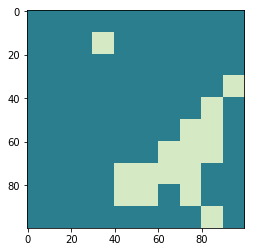

In [13]:
def cluster_by_color(im,n=3):
    '''Use k-means cluster analysis to find n colors in image'''
    df = pd.DataFrame(list(im.getdata()))
    k_means = cluster.KMeans(n_clusters=n)
    k_means.fit(df) 
    return k_means

def draw_with_cluster_colors(im,k_means):
    '''Given k_means cluster model (already fit to image colors), 
    recolor each pixel with the color of its cluster's center'''
    colors = [tuple([int(c) for c in color]) for color in k_means.cluster_centers_]
    w = im.size[0]
    for i,label in enumerate(k_means.labels_):
        xy = ((int(i%w),int(i/w)))
        color = colors[label]
        im.putpixel(xy,color)
    return im

def reduce_to_n_colors(im,n=3):
    '''Recolor an image with only n colors, selected via cluster analysis'''
    k_means = cluster_by_color(im,n=n)
    new_im = draw_with_cluster_colors(im,k_means)
    return new_im

im_small = im.crop((0,0,100,100))
show(reduce_to_n_colors(im_small))

# Blockify: Reduce colors and pixelate

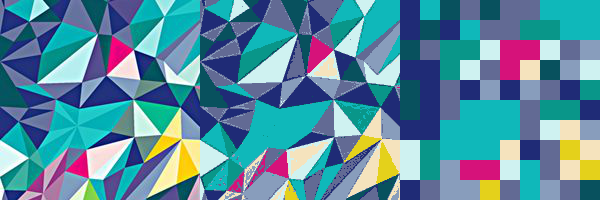

In [28]:
def blockify(im,n=10,w=20,h=20):
    '''Given an image, reduce the number of colors (to n colors)
    and then pixelate to blocks of given size (w, h). Returns a list
    of images: original, reduced, and pixelated'''
    images = [im]
    imc = reduce_to_n_colors(im.copy(),n=n)
    imcp = pixelate(imc.copy(),w=w,h=h)
    images += [imc,imcp]
    return images

path_in = 'data/input/heart_prism.jpg'
im = Image.open(path_in)
im_small = im.crop((0,0,200,200)).copy()
images = blockify(im_small)
concatxy(images)

# Cool examples!

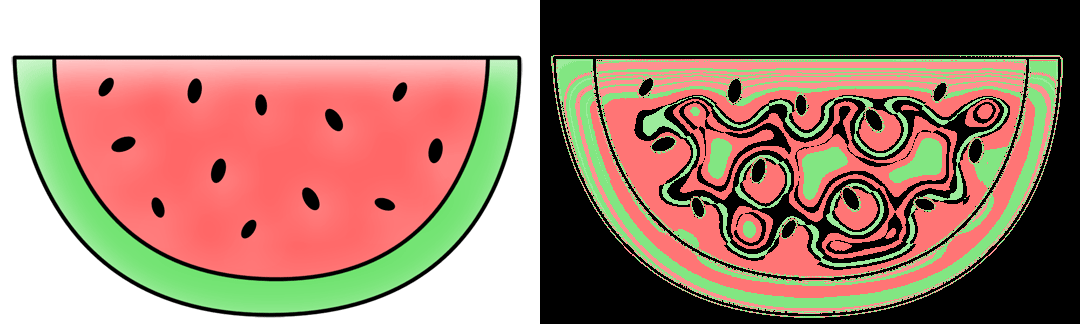

In [23]:
path_in = 'data/input/watermelon.gif'
im_watermelon = Image.open(path_in)
im_watermelon_recolored = reduce_to_n_colors(im_watermelon.copy(),n=5)
concatxy([im_watermelon,im_watermelon_recolored])

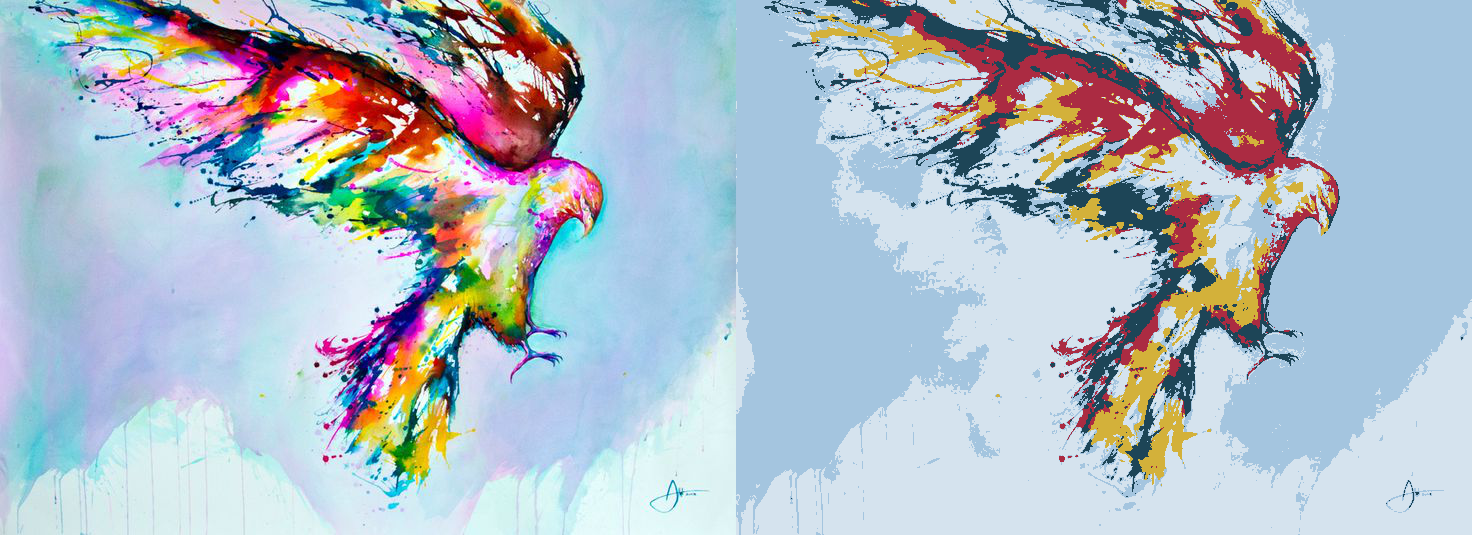

In [24]:
path_in = 'data/input/bird.jpg'
im_bird = Image.open(path_in)
im_bird_recolored = reduce_to_n_colors(im_bird.copy(),n=5)
concatxy([im_bird,im_bird_recolored])